# Tempo estimation and beat tracking  

### George Tzanetakis, University of Victoria 

In this notebook we will explore the basic concepts behind tempo estimation and beat tracking. 


In [72]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.interpolate import interp1d 

import IPython.display as ipd

Let's also load an audio recording

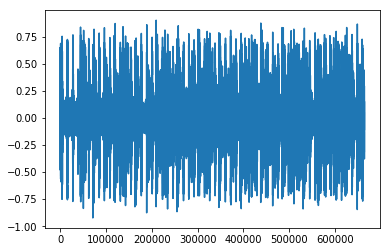

In [73]:
import scipy.io.wavfile as wav
srate, audio_signal = wav.read("disco.00000.wav")
# scale to -1.0/1.0 
audio = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
audio= (0.9 / max(audio)) * audio

plt.figure() 
plt.plot(audio)
ipd.Audio(audio,rate=srate)


Now that we have seen how we can estimate the pitch of a single frame of audio 
we can abstract this process into functions and then write a function that 
given an audio signal returns the associated pitch track and amplitude track (RMS) 
using a particular pitch extraction method. 

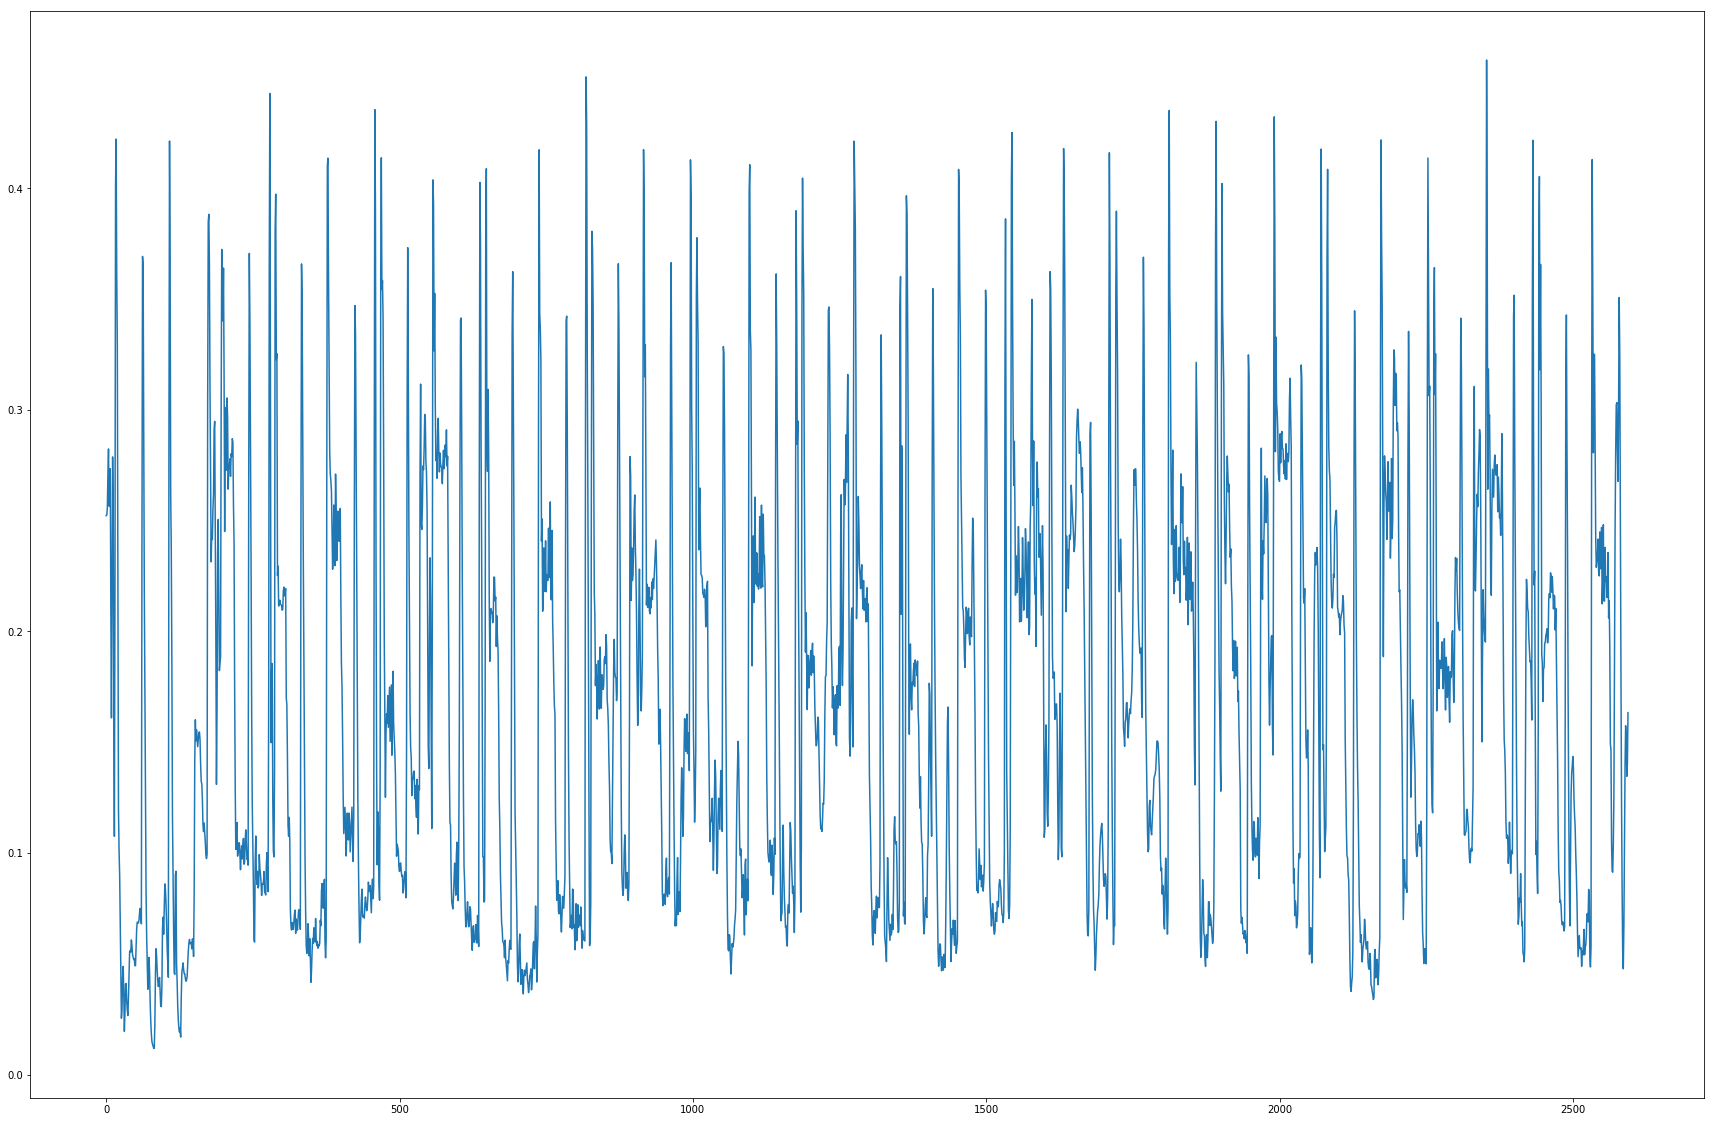

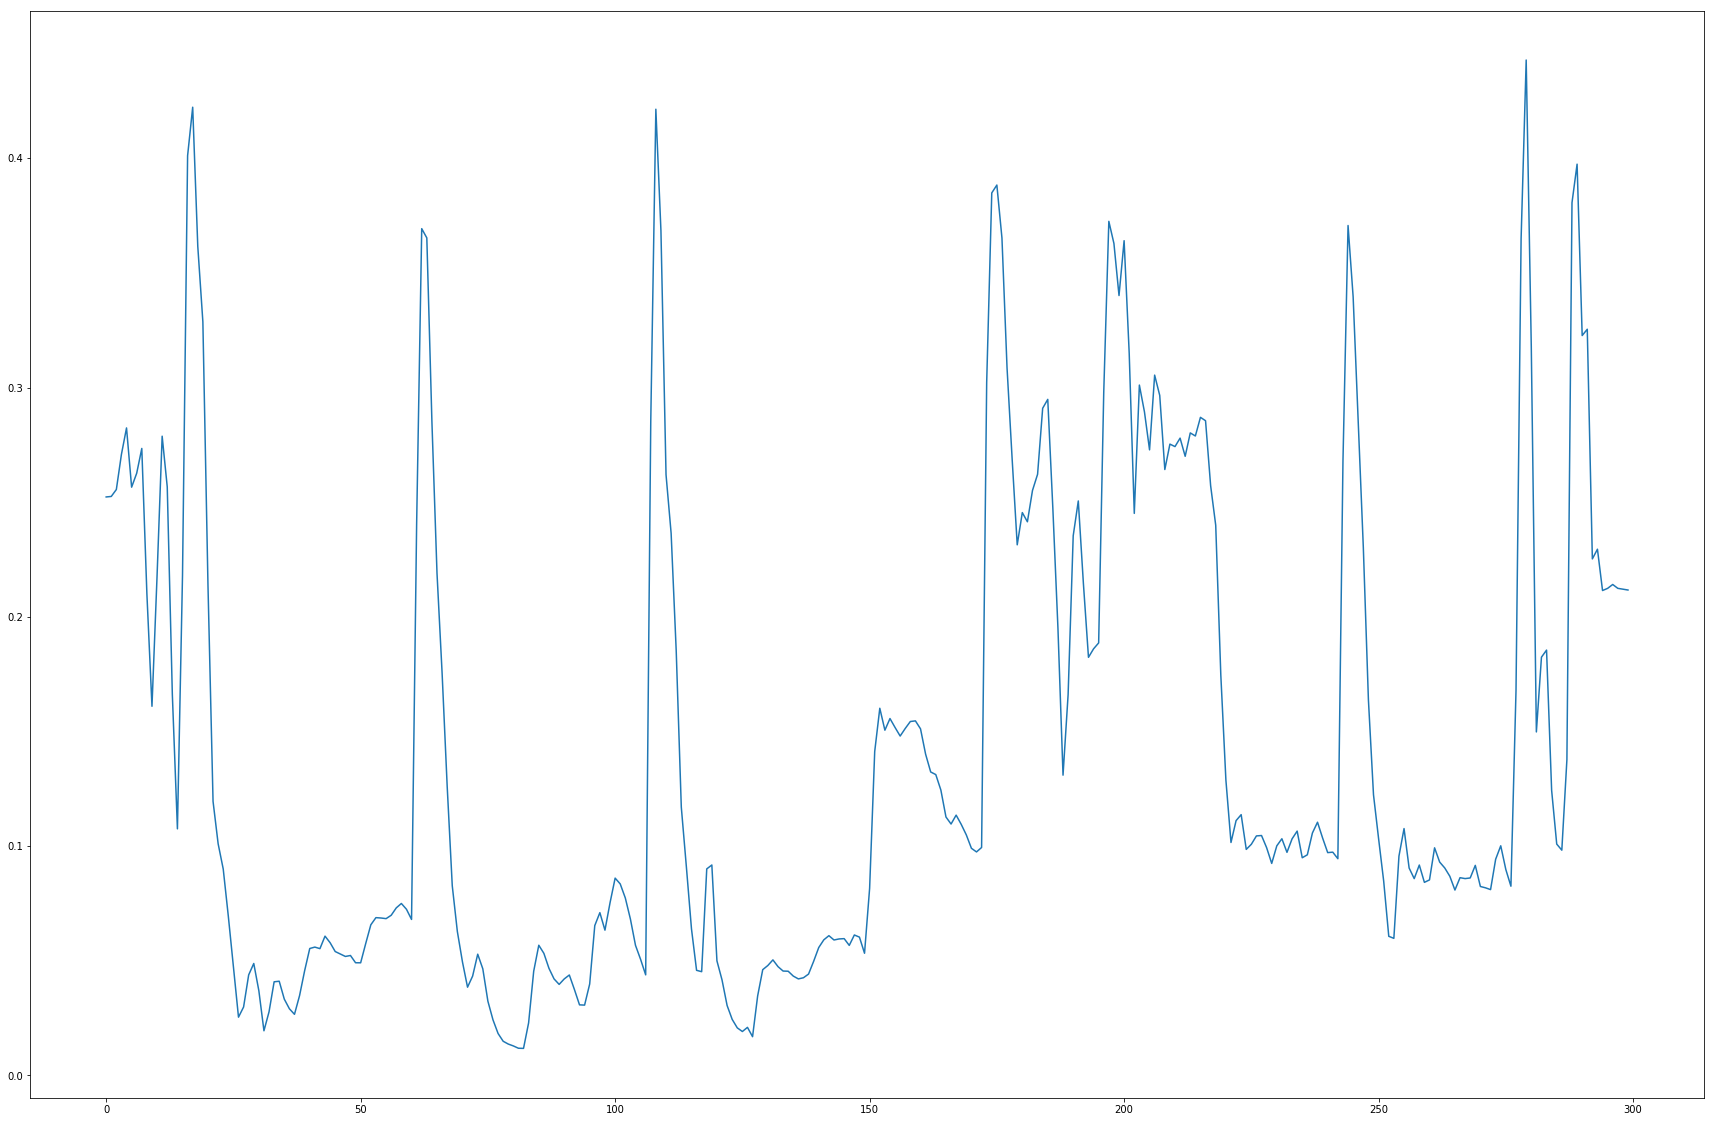

In [74]:

def rms_track(data, hopSize, winSize): 
    offsets = np.arange(0, len(data), hopSize)
    rms_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = data[o:o+winSize] 
        rms_track[m] = np.sqrt(np.mean(np.square(frame)))  
    return (rms_track)
    
# compute the pitch track 
hopSize = 256 
winSize = 512
pt = rms_track(audio, hopSize, winSize)

plt.figure(figsize=(30,20)) 
plt.plot(pt)
plt.figure(figsize=(30,20))
plt.plot(pt[:300])

    

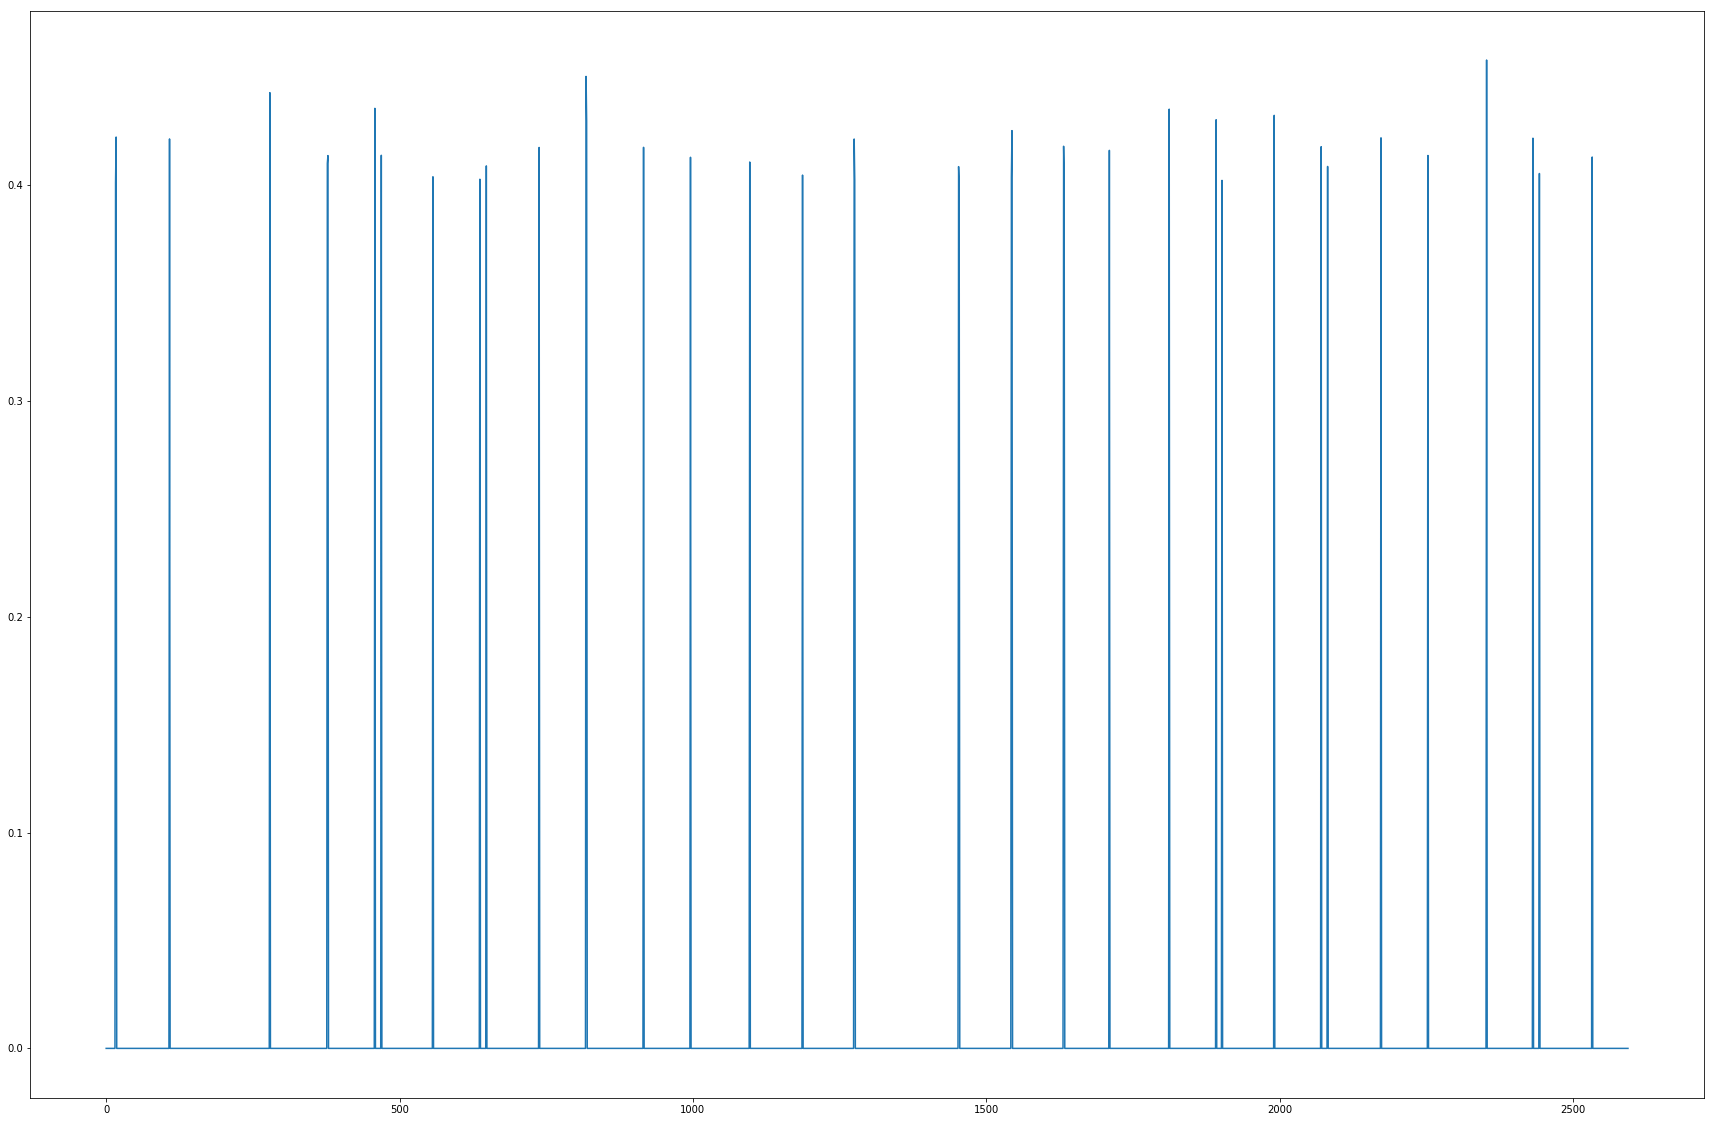

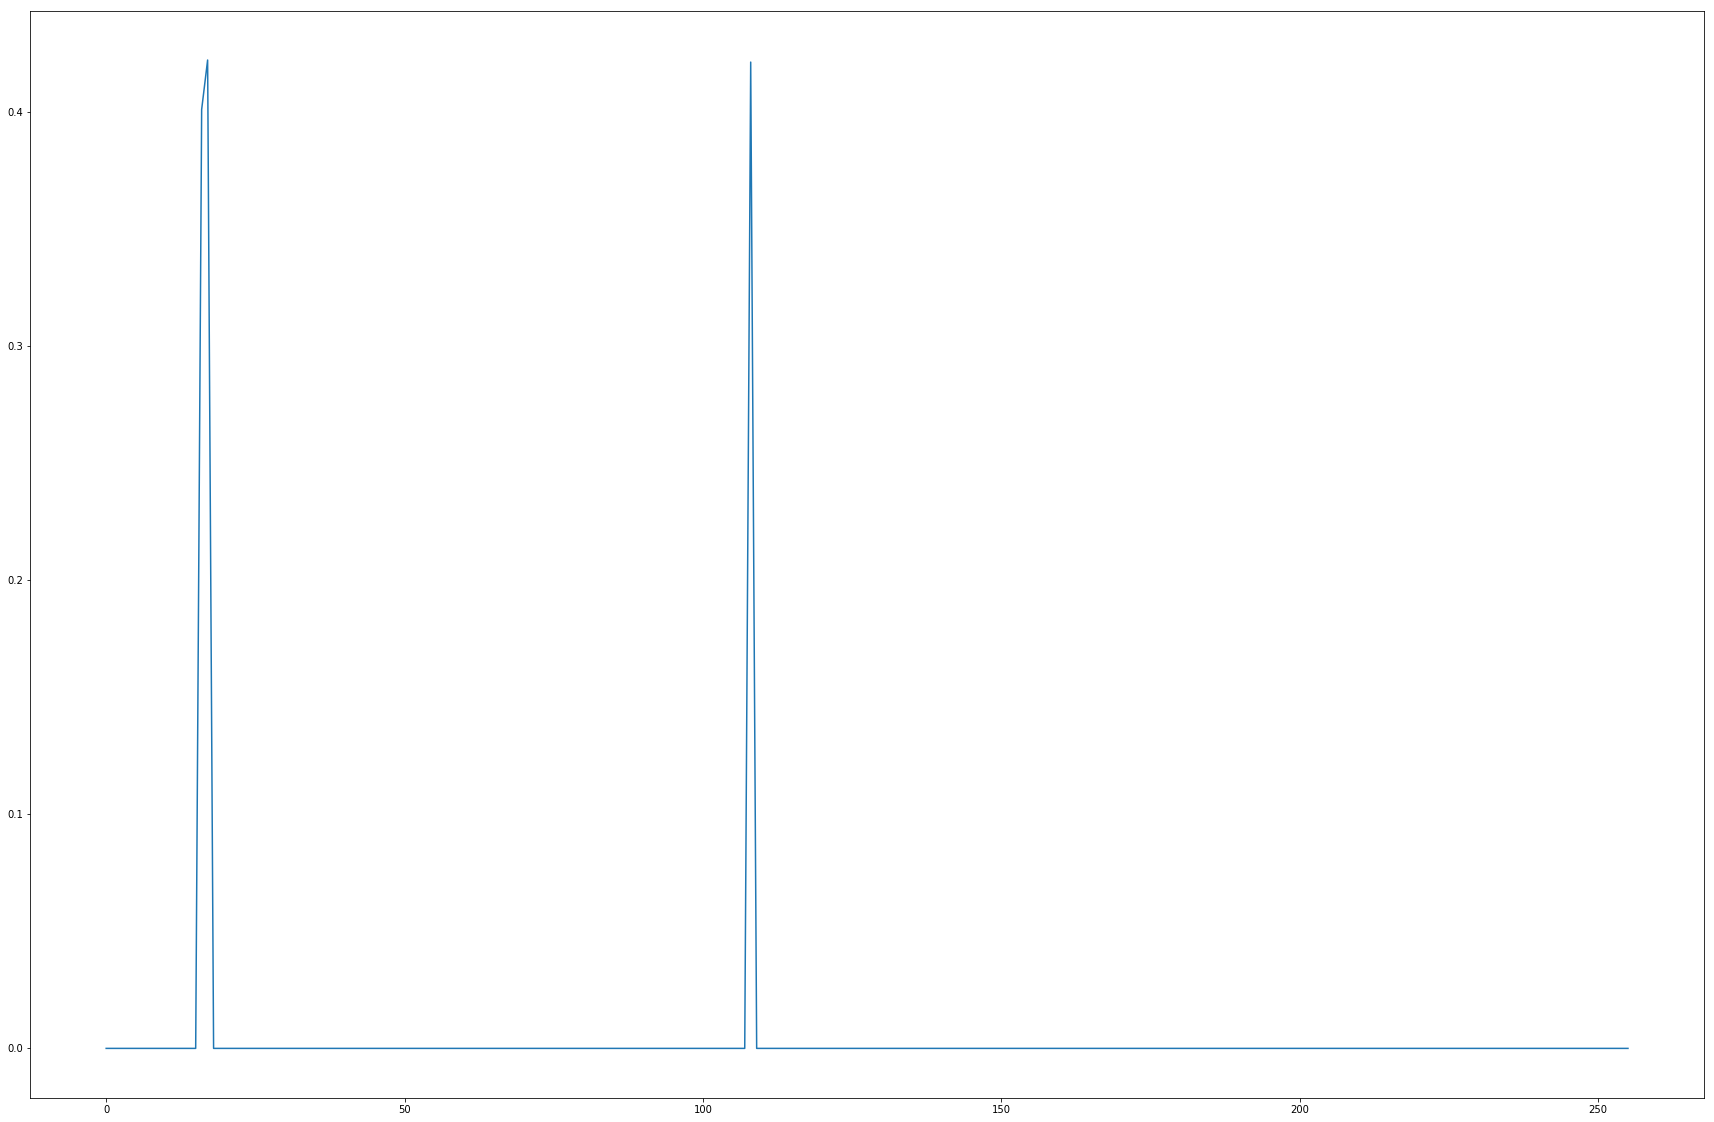

In [76]:
peaks = np.where(pt<0.4, 0, pt)
plt.figure(figsize=(30,20)) 
plt.plot(peaks)
plt.figure(figsize=(30,20))
plt.plot(peaks[:256])

In [77]:
indices = np.nonzero(peaks)[0]
print(np.diff(indices))

[  1  91 171  98   1  80  11  88  80  11  90  80   1  97  80 101  90  88
   1 177   1  89   1  88   1  77 102  80  10  89  80  11  91  80 100  79
  11  90]


In [83]:
period_in_frames = np.median(np.diff(indices))
print(period_in_frames)
period_in_samples = period_in_frames * hopSize
print(period_in_samples)

80.0
20480.0


In [84]:
period_in_secs = period_in_samples / srate
print(period_in_samples / srate)

0.9287981859410431


In [85]:
bpm = 60.0 / period_in_secs 
print("Tempo estimate (BPM): %2.2f" %  bpm)

Tempo estimate (BPM): 64.60


In [86]:
# noise burst 
noise = np.random.normal(0, 1.0, winSize)
noise *= np.hanning(winSize)


def sonify_onsets(audio, hopSize, indices): 
    # output signal 
    osignal = np.zeros(len(audio))
    k = 1 

    offsets = np.arange(0, len(audio), hopSize)
    for (m,o) in enumerate(offsets): 
        iframe = audio[o:o+winSize] 
        oframe = 0.4 * iframe 


        # replace frame with noise if the frame corresponds to an onset  
        if ((k < len(indices)) and (m == indices[k:][0])): 
            k += 1
            osignal[o:o+winSize] += noise
        else: 
            osignal[o:o+winSize] += oframe 
    return osignal 

osignal = sonify_onsets(audio, hopSize, indices)
ipd.Audio(osignal,rate=srate)

In [87]:
tempo_onset = indices[1]
tempo_indices = [tempo_onset] 
while tempo_onset * hopSize < len(audio): 
    tempo_onset = tempo_onset + period_in_frames
    tempo_indices.append(tempo_onset)
print(tempo_indices)

osignal = sonify_onsets(audio, hopSize, tempo_indices)
ipd.Audio(osignal,rate=srate)

[17, 97.0, 177.0, 257.0, 337.0, 417.0, 497.0, 577.0, 657.0, 737.0, 817.0, 897.0, 977.0, 1057.0, 1137.0, 1217.0, 1297.0, 1377.0, 1457.0, 1537.0, 1617.0, 1697.0, 1777.0, 1857.0, 1937.0, 2017.0, 2097.0, 2177.0, 2257.0, 2337.0, 2417.0, 2497.0, 2577.0, 2657.0]


91
Tempo estimate (BPM): 56.79


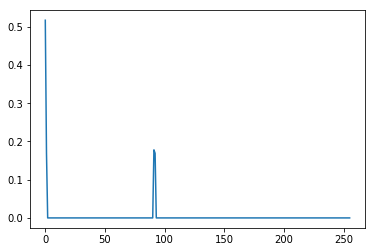

In [88]:
peaks = peaks[:256]
acr = np.correlate(peaks, peaks, mode='full')
acr = acr[int(len(acr)/2):]
plt.plot(acr)
acr_peak_location = np.argmax(acr[1:])+1
print(acr_peak_location)
bpm = 60.0 * (float(srate) / (acr_peak_location * hopSize))
print("Tempo estimate (BPM): %2.2f" %  bpm)


In [89]:
tempo_indices[0::4]

[17, 337.0, 657.0, 977.0, 1297.0, 1617.0, 1937.0, 2257.0, 2577.0]

In [90]:
nbeats = 8 

avg_bar = np.zeros(44 * nbeats * hopSize)
for (n,t) in enumerate(tempo_indices[0::nbeats]): 
    bar = audio[int(t) * hopSize: int(t)* hopSize + 44 * nbeats * hopSize]
    if (n < len(tempo_indices[0::nbeats])-1):
        avg_bar += bar
ipd.Audio(avg_bar,rate=srate)